<a href="https://colab.research.google.com/github/tomifarall/Orga-Datos-Tp2/blob/master/feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re as re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
from tensorflow.keras.layers import Dense, Dropout, Flatten

import tensorflow.keras.backend as K

In [18]:
#ESTO NO LO EJECUTEN SI UTILIZAN UNA VERSION DE PC , YO LO HAGO PARA PODER USAR EL TRAIN DE MI DRIVE,Y USAR EL GITHUB ONLINE
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [19]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1BDGyvJqONz4gk2Y0BK1Ag1DA9yujd44e'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data_uni_loca_1.csv')

In [20]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '18Ab39T1hPgTBv58oXdVk0NfBE36Fp21D'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_uni_loca_1.csv')


In [21]:
#Cargamos los datos

train_data = pd.read_csv("data_uni_loca_1.csv")
test_data = pd.read_csv('test_uni_loca_1.csv')

In [22]:
train_data.head()

,Unnamed: 0,id,keyword,location,text,target,clean_text
0,0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze
1,1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt
2,2,50,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...
3,3,52,ablaze,Philadelphia,Crying out for more! Set me ablaze,0,cry set ablaze
4,4,53,ablaze,Florida,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze


In [23]:
#Corregimos algunos nulos del set de train

train_data['keyword'].fillna('no keyword', inplace = True) 
train_data['keyword'] = train_data['keyword'].str.replace('%20', ' ')
train_data['location'].fillna('no location', inplace = True)
train_data.drop(['id'], 1, inplace = True)
#test_data.drop(['id'], 1, inplace = True)

In [24]:
#Corregimos algunos nulos del set de test
test_data['keyword'].fillna('no keyword', inplace = True)
test_data['keyword'] = train_data['keyword'].str.replace('%20', ' ')
test_data['location'].fillna('no location', inplace = True)

In [25]:
#FUNCIONES UTILES

import nltk
#nltk.download('stopwords') 
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

stop_words=set(stopwords.words("english"))

def filter_stopwords(tokenized_text):
    filtered_words=[]
    for w in tokenized_text:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

lemmatizer = WordNetLemmatizer()

def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

def transform_to_text(tweet_words):
    return " ".join(tweet_words)

custom_sent_tokenizer = PunktSentenceTokenizer()

def process_content(sentence):
    tokenized = custom_sent_tokenizer.tokenize(sentence)
    words_tagged = []
    for i in tokenized:
        words = nltk.word_tokenize(i)
        tagged = nltk.pos_tag(words)
        for word in tagged:
            words_tagged.append(word)
            
    return words_tagged

#Cleaning text

train_data['clean_text'] = train_data['text'].str.lower()
test_data['clean_text'] = test_data['text'].str.lower()

train_data['clean_text'] = train_data['clean_text'].apply(only_letters)    
test_data['clean_text'] = test_data['clean_text'].apply(only_letters)   

#Tokenización

train_data['clean_text'] = train_data['clean_text'].apply(word_tokenize)
test_data['clean_text'] = test_data['clean_text'].apply(word_tokenize)

#Remove stopwords

train_data['clean_text'] = train_data['clean_text'].apply(filter_stopwords) 
test_data['clean_text'] = test_data['clean_text'].apply(filter_stopwords)

#Lemmatization                                                                       

train_data['clean_text'] = train_data['clean_text'].apply(lemmatize_tweet)
test_data['clean_text'] = test_data['clean_text'].apply(lemmatize_tweet)

#Transform to text
train_data['clean_text'] = train_data['clean_text'].apply(transform_to_text)
test_data['clean_text'] = test_data['clean_text'].apply(transform_to_text)

#Part of speech tagging

train_data['tagged_text']= train_data['text'].apply(process_content)
train_data['tagged_clean_text']= train_data['clean_text'].apply(process_content)

test_data['tagged_text']= test_data['text'].apply(process_content)
test_data['tagged_clean_text']= test_data['clean_text'].apply(process_content)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
#Agregando features
def count_Nouns(list):
    nouns = 0
    for word,tag in list:
        if tag[0] == 'N':
            nouns += 1
        else:
            continue
    return nouns

def count_Adjetives(list):
    adjetives = 0
    for word,tag in list:
        if tag[0] == 'J':
            adjetives += 1
        else:
            continue
    return adjetives

def count_Verbs(list):
    verbs = 0
    for word,tag in list:
        if tag[0] == 'V':
            verbs += 1
        else:
            continue
    return verbs 


# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# length
train_data['tweet_length'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['tweet_length'] = test_data['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_data['punctuation_count'] = train_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_data['punctuation_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_data['hashtag_count'] = train_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_data['hashtag_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_data['mention_count'] = train_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_data['mention_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

#noun_count
train_data['noun_count'] = train_data['tagged_text'].apply(count_Nouns)
test_data['noun_count'] = test_data['tagged_text'].apply(count_Nouns)

#verb_count
train_data['verb_count'] = train_data['tagged_text'].apply(count_Verbs)
test_data['verb_count'] = test_data['tagged_text'].apply(count_Verbs)

#adjetives_count
train_data['adjetives_count'] = train_data['tagged_text'].apply(count_Adjetives)
test_data['adjetives_count'] = test_data['tagged_text'].apply(count_Adjetives)

In [27]:
#más features

train_data['length'] = train_data['text'].str.len()
test_data['length'] = test_data['text'].str.len()

keywords_list = list(set(train_data.keyword))  #todas las keywords únicas

locations_list = list(set(train_data.location)) #todas las locaciones únicas
locations_list.remove('no location')

def amount_keywords(tweet):
    cont = 0
    for keyword in keywords_list:
        if keyword in tweet:
            cont += 1
    return cont

train_data['amount_words_clean_text'] = train_data['clean_text'].str.split(' ').apply(lambda x: len(x))  

test_data['amount_words_clean_text'] = test_data['clean_text'].str.split(' ').apply(lambda x: len(x))  

train_data['amount_keywords_in_tweet'] = train_data['clean_text'].apply(lambda x: amount_keywords(x))

test_data['amount_keywords_in_tweet'] = test_data['clean_text'].apply(lambda x: amount_keywords(x))

def amount_locations(tweet):    #esta función podría unificarse con la de keywords pasandole por parámetro la lista a recorrer
    cont = 0
    for location in locations_list:
        if location in tweet:
            cont += 1
    return cont

train_data['amount_locations_in_tweet'] = train_data['clean_text'].apply(lambda x: amount_locations(x))

test_data['amount_locations_in_tweet'] = test_data['clean_text'].apply(lambda x: amount_locations(x))

In [28]:
#más features
def get_hashtags(s):
    return list(part[1:] for part in s.split() if part.startswith('#'))

train_data['hashtags'] = train_data['text'].apply(get_hashtags)
test_data['hashtags'] = test_data['text'].apply(get_hashtags)

def hashtag_length_proportion(hashtags, length):
    return len(''.join(hashtags))/length

train_data['len_hash_over_text'] = train_data.apply(lambda data: hashtag_length_proportion(data['hashtags'], data['length']), axis=1)
test_data['len_hash_over_text'] = test_data.apply(lambda data: hashtag_length_proportion(data['hashtags'], data['length']), axis=1)

train_data.drop(['hashtags'], axis=1)
test_data.drop(['hashtags'], axis=1)

# def get_mentioned_users(s):
#     return list(part[1:] for part in s.split() if part.startswith('@'))

# train['users'] = train['text'].apply(get_mentioned_users)
# test['users'] = test['text'].apply(get_mentioned_users)

# def amount_hashtags(l):
#     return len(l)

# train['amount_hashtags'] = train['hashtags'].apply(amount_hashtags)
# test['amount_hashtags'] = test['hashtags'].apply(amount_hashtags)

# def amount_users(l):
#     return len(l)

def has_url(text):
    return int('http' in text)

train_data['has_url'] = train_data['text'].apply(has_url)
test_data['has_url'] = test_data['text'].apply(has_url)

# def find_url(text):
#     urls = re.findall(r'(https?://\S+)', text)
#     return urls

# train['urls'] = train['text'].apply(find_url)
# test['urls'] = test['text'].apply(find_url)
# train['amount_urls'] = train['urls'].apply(lambda x: len(x))
# test['amount_urls'] = test['urls'].apply(lambda x: len(x))

# train['amount_users'] = train['users'].apply(amount_users)
# test['amount_users'] = test['users'].apply(amount_users)

In [29]:
train_data.head()

,Unnamed: 0,keyword,location,text,target,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url
0,0,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,"[(@, NN), (bbcmtd, JJ), (Wholesale, NNP), (Mar...","[(bbcmtd, JJ), (wholesale, JJ), (market, NN), ...",5,5,0,1,10.200000,55,6,0,1,5,1,1,55,4,2,1,[],0.000000,1
1,1,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt,"[(We, PRP), (always, RB), (try, VBP), (to, TO)...","[(always, RB), (try, VB), (bring, VBG), (heavy...",10,10,3,1,5.800000,67,8,2,0,5,2,0,67,6,0,0,"[metal, RT]",0.104478,1
2,2,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,"[(#, #), (AFRICANBAZE, NNP), (:, :), (Breaking...","[(africanbaze, NN), (breaking, VBG), (newsnige...",9,9,1,1,8.222222,82,9,1,0,7,2,1,82,7,2,2,[AFRICANBAZE:],0.146341,1
3,3,ablaze,Philadelphia,Crying out for more! Set me ablaze,0,cry set ablaze,"[(Crying, VBG), (out, RP), (for, IN), (more, J...","[(cry, NN), (set, NN), (ablaze, NN)]",7,7,3,0,4.000000,34,1,0,0,1,2,1,34,3,2,1,[],0.000000,0
4,4,ablaze,Florida,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,"[(On, IN), (plus, CC), (side, JJ), (LOOK, NNP)...","[(plus, CC), (side, JJ), (look, NN), (sky, NN)...",13,13,5,1,4.923077,76,5,0,0,11,0,1,76,7,2,2,[],0.000000,1


In [30]:
test_data.head()

,Unnamed: 0,id,keyword,location,text,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url
0,0,46,ablaze,Florida,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news fi...,"[(Birmingham, NNP), (Wholesale, NNP), (Market,...","[(birmingham, JJ), (wholesale, JJ), (market, N...",16,14,3,1,6.562500,120,7,0,0,10,2,2,120,11,3,2,[],0.000000,1
1,1,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,"[(@, NN), (sunkxssedharry, NN), (will, MD), (y...","[(sunkxssedharry, NN), (wear, WRB), (short, JJ...",9,9,3,0,5.111111,54,2,0,1,5,1,0,54,5,3,2,[],0.000000,0
2,2,51,ablaze,Nigeria,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwas marriage cri...,"[(#, #), (PreviouslyOnDoyinTv, NN), (:, :), (T...","[(previouslyondoyintv, NN), (toke, NN), (makin...",10,10,0,1,10.000000,109,10,1,0,10,0,1,109,9,2,2,[PreviouslyOnDoyinTv:],0.183486,1
3,3,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,"[(Check, VB), (these, DT), (out, IN), (:, :), ...","[(check, NN), (nsfw, NN)]",8,8,1,4,13.375000,114,22,1,0,5,1,4,114,2,0,0,[nsfw],0.035088,1
4,4,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...,psa im splitting personality techie follow abl...,"[(PSA, NN), (:, :), (IÛªm, NNP), (splitting, ...","[(psa, NN), (im, NN), (splitting, VBG), (perso...",13,11,1,0,6.230769,94,9,0,2,8,3,0,94,10,2,1,[],0.000000,0


## TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range= (1,2))

#Corremos el algoritmo para TRAIN set 
texts = train_data['clean_text']
features = tf_idf.fit_transform(texts)
feature_words = tf_idf.get_feature_names()
df_tf_idf = pd.DataFrame(data = features.todense(), columns = tf_idf.get_feature_names())
df_tf_idf["_target_"] = train_data.target
df_tf_idf = df_tf_idf.reset_index()
df_tf_idf.head()


,index,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,abc online,abcnews,abcnews obama,abe,abia,ability,ablaze,ablaze amp,ablaze california,able,abomb,abomination,abomination maketh,abortion,absolute,absolutely,absolutely demolished,abstorm,abstorm yyc,abubaraa,abuse,abused,abuseddesolateamplost,abuseddesolateamplost lovely,abusing,abusing child,ac,...,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened,_target_
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.376739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.0,0.0,0.433626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.474729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
#Corremos el algoritmo para TEST set 
texts_test = test_data['clean_text']

features_test = tf_idf.transform(texts_test)

feature_words_test = tf_idf.get_feature_names()

df_tf_idf_test = pd.DataFrame(data = features_test.todense(), columns = tf_idf.get_feature_names())

df_tf_idf_test = df_tf_idf_test.reset_index()
df_tf_idf_test.head()

,index,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,abc online,abcnews,abcnews obama,abe,abia,ability,ablaze,ablaze amp,ablaze california,able,abomb,abomination,abomination maketh,abortion,absolute,absolutely,absolutely demolished,abstorm,abstorm yyc,abubaraa,abuse,abused,abuseddesolateamplost,abuseddesolateamplost lovely,abusing,abusing child,ac,...,youth,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train_data = train_data.reset_index()  
train_data.head()

,index,Unnamed: 0,keyword,location,text,target,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url
0,0,0,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,"[(@, NN), (bbcmtd, JJ), (Wholesale, NNP), (Mar...","[(bbcmtd, JJ), (wholesale, JJ), (market, NN), ...",5,5,0,1,10.200000,55,6,0,1,5,1,1,55,4,2,1,[],0.000000,1
1,1,1,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt,"[(We, PRP), (always, RB), (try, VBP), (to, TO)...","[(always, RB), (try, VB), (bring, VBG), (heavy...",10,10,3,1,5.800000,67,8,2,0,5,2,0,67,6,0,0,"[metal, RT]",0.104478,1
2,2,2,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,"[(#, #), (AFRICANBAZE, NNP), (:, :), (Breaking...","[(africanbaze, NN), (breaking, VBG), (newsnige...",9,9,1,1,8.222222,82,9,1,0,7,2,1,82,7,2,2,[AFRICANBAZE:],0.146341,1
3,3,3,ablaze,Philadelphia,Crying out for more! Set me ablaze,0,cry set ablaze,"[(Crying, VBG), (out, RP), (for, IN), (more, J...","[(cry, NN), (set, NN), (ablaze, NN)]",7,7,3,0,4.000000,34,1,0,0,1,2,1,34,3,2,1,[],0.000000,0
4,4,4,ablaze,Florida,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,"[(On, IN), (plus, CC), (side, JJ), (LOOK, NNP)...","[(plus, CC), (side, JJ), (look, NN), (sky, NN)...",13,13,5,1,4.923077,76,5,0,0,11,0,1,76,7,2,2,[],0.000000,1


In [34]:
test_data = test_data.reset_index()  
test_data.head()

,index,Unnamed: 0,id,keyword,location,text,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url
0,0,0,46,ablaze,Florida,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news fi...,"[(Birmingham, NNP), (Wholesale, NNP), (Market,...","[(birmingham, JJ), (wholesale, JJ), (market, N...",16,14,3,1,6.562500,120,7,0,0,10,2,2,120,11,3,2,[],0.000000,1
1,1,1,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,"[(@, NN), (sunkxssedharry, NN), (will, MD), (y...","[(sunkxssedharry, NN), (wear, WRB), (short, JJ...",9,9,3,0,5.111111,54,2,0,1,5,1,0,54,5,3,2,[],0.000000,0
2,2,2,51,ablaze,Nigeria,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwas marriage cri...,"[(#, #), (PreviouslyOnDoyinTv, NN), (:, :), (T...","[(previouslyondoyintv, NN), (toke, NN), (makin...",10,10,0,1,10.000000,109,10,1,0,10,0,1,109,9,2,2,[PreviouslyOnDoyinTv:],0.183486,1
3,3,3,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,"[(Check, VB), (these, DT), (out, IN), (:, :), ...","[(check, NN), (nsfw, NN)]",8,8,1,4,13.375000,114,22,1,0,5,1,4,114,2,0,0,[nsfw],0.035088,1
4,4,4,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...,psa im splitting personality techie follow abl...,"[(PSA, NN), (:, :), (IÛªm, NNP), (splitting, ...","[(psa, NN), (im, NN), (splitting, VBG), (perso...",13,11,1,0,6.230769,94,9,0,2,8,3,0,94,10,2,1,[],0.000000,0


In [35]:
train_data = train_data.merge(df_tf_idf, how='inner',on='index')
train_data.head()

,index,Unnamed: 0,keyword,location_x,text_x,target_x,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,...,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened,_target_
0,0,0,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,"[(@, NN), (bbcmtd, JJ), (Wholesale, NNP), (Mar...","[(bbcmtd, JJ), (wholesale, JJ), (market, NN), ...",5,5,0,1,10.200000,55,6,0,1,5,1,1,55,4,2,1,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,1,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt,"[(We, PRP), (always, RB), (try, VBP), (to, TO)...","[(always, RB), (try, VB), (bring, VBG), (heavy...",10,10,3,1,5.800000,67,8,2,0,5,2,0,67,6,0,0,"[metal, RT]",0.104478,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,2,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,"[(#, #), (AFRICANBAZE, NNP), (:, :), (Breaking...","[(africanbaze, NN), (breaking, VBG), (newsnige...",9,9,1,1,8.222222,82,9,1,0,7,2,1,82,7,2,2,[AFRICANBAZE:],0.146341,1,0.0,0.0,0.433626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,3,ablaze,Philadelphia,Crying out for more! Set me ablaze,0,cry set ablaze,"[(Crying, VBG), (out, RP), (for, IN), (more, J...","[(cry, NN), (set, NN), (ablaze, NN)]",7,7,3,0,4.000000,34,1,0,0,1,2,1,34,3,2,1,[],0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,4,ablaze,Florida,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,"[(On, IN), (plus, CC), (side, JJ), (LOOK, NNP)...","[(plus, CC), (side, JJ), (look, NN), (sky, NN)...",13,13,5,1,4.923077,76,5,0,0,11,0,1,76,7,2,2,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [36]:
test_data = test_data.merge(df_tf_idf_test, how='inner',on='index')
test_data.head()

,index,Unnamed: 0,id_x,keyword,location_x,text_x,clean_text,tagged_text,tagged_clean_text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,...,youth,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened
0,0,0,46,ablaze,Florida,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news fi...,"[(Birmingham, NNP), (Wholesale, NNP), (Market,...","[(birmingham, JJ), (wholesale, JJ), (market, N...",16,14,3,1,6.562500,120,7,0,0,10,2,2,120,11,3,2,[],0.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,"[(@, NN), (sunkxssedharry, NN), (will, MD), (y...","[(sunkxssedharry, NN), (wear, WRB), (short, JJ...",9,9,3,0,5.111111,54,2,0,1,5,1,0,54,5,3,2,[],0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,51,ablaze,Nigeria,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwas marriage cri...,"[(#, #), (PreviouslyOnDoyinTv, NN), (:, :), (T...","[(previouslyondoyintv, NN), (toke, NN), (makin...",10,10,0,1,10.000000,109,10,1,0,10,0,1,109,9,2,2,[PreviouslyOnDoyinTv:],0.183486,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,"[(Check, VB), (these, DT), (out, IN), (:, :), ...","[(check, NN), (nsfw, NN)]",8,8,1,4,13.375000,114,22,1,0,5,1,4,114,2,0,0,[nsfw],0.035088,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...,psa im splitting personality techie follow abl...,"[(PSA, NN), (:, :), (IÛªm, NNP), (splitting, ...","[(psa, NN), (im, NN), (splitting, VBG), (perso...",13,11,1,0,6.230769,94,9,0,2,8,3,0,94,10,2,1,[],0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
train_data.drop(["_target_",'index','clean_text','text_x','target_x','keyword','location_x','tagged_text','tagged_clean_text'], axis=1)


,Unnamed: 0,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,abc online,abcnews,abcnews obama,abe,abia,ability,ablaze,ablaze amp,...,youth,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened
0,0,5,5,0,1,10.200000,55,6,0,1,5,1,1,55,4,2,1,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.376739,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,10,10,3,1,5.800000,67,8,2,0,5,2,0,67,6,0,0,"[metal, RT]",0.104478,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,9,9,1,1,8.222222,82,9,1,0,7,2,1,82,7,2,2,[AFRICANBAZE:],0.146341,1,0.0,0.0,0.433626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394085,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7,7,3,0,4.000000,34,1,0,0,1,2,1,34,3,2,1,[],0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.474729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,13,13,5,1,4.923077,76,5,0,0,11,0,1,76,7,2,2,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354690,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,7605,26,25,16,0,3.423077,114,1,0,0,4,5,2,114,10,2,2,[],0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,7606,20,18,1,1,5.100000,121,11,0,0,14,0,0,121,13,3,1,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,7608,11,11,2,1,6.636364,83,5,0,0,6,1,2,83,8,2,0,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,7610,8,8,2,1,7.250000,65,11,0,0,8,1,0,65,3,1,0,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [40]:
#Random Forest Classifier - importancias de los features

In [ ]:
  train_tfidf=train_tfidf.drop( columns='Unnamed: 0')
  train_tfidf=train_tfidf.drop( columns='keyword')
  train_tfidf=train_tfidf.drop( columns='location')
  train_tfidf=train_tfidf.drop( columns='clean_text')
  train_tfidf=train_tfidf.drop( columns='regularizacion_mean')
  train_tfidf=train_tfidf.drop( columns='mean_target_global')
  train_tfidf=train_tfidf.drop( columns='nrow')
  train_tfidf=train_tfidf.drop( columns='mean_encoding_location')
  train_tfidf=train_tfidf.drop( columns='mean_encoding_keyword')

In [52]:
 train_data.drop(['Unnamed: 0','hashtags',"_target_",'index','clean_text','text_x','target_x','keyword','location_x','tagged_text','tagged_clean_text'], axis=1)


,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,tweet_length,punctuation_count,hashtag_count,mention_count,noun_count,verb_count,adjetives_count,length,amount_words_clean_text,amount_keywords_in_tweet,amount_locations_in_tweet,hashtags,len_hash_over_text,has_url,aa,ab,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,abc online,abcnews,abcnews obama,abe,abia,ability,ablaze,ablaze amp,ablaze california,...,youth,youth explosion,youth saved,youtube,youtube channel,youtube military,youtube playlist,youtube video,youve,youve home,ypres,ypres road,yr,yr ago,yr everyone,yr old,yugvani,yyc,yyc abstorm,yyc yycstorm,yycstorm,zakbagans,zarry,zayn,zaynmalik,zero,zimbabwe,zionism,zionist,zionist terrorist,zippednews,zipper,zipper bag,zombie,zombie apocalypse,zone,zone coming,zone dont,zouma,zouma flattened
0,5,5,0,1,10.200000,55,6,0,1,5,1,1,55,4,2,1,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.376739,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,10,3,1,5.800000,67,8,2,0,5,2,0,67,6,0,0,"[metal, RT]",0.104478,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,9,1,1,8.222222,82,9,1,0,7,2,1,82,7,2,2,[AFRICANBAZE:],0.146341,1,0.0,0.0,0.433626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394085,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,7,3,0,4.000000,34,1,0,0,1,2,1,34,3,2,1,[],0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.474729,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,13,5,1,4.923077,76,5,0,0,11,0,1,76,7,2,2,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354690,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,26,25,16,0,3.423077,114,1,0,0,4,5,2,114,10,2,2,[],0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,20,18,1,1,5.100000,121,11,0,0,14,0,0,121,13,3,1,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,11,11,2,1,6.636364,83,5,0,0,6,1,2,83,8,2,0,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,8,8,2,1,7.250000,65,11,0,0,8,1,0,65,3,1,0,[],0.000000,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [53]:
#Construimos los datos de entrenamiento y de test
X=train_data.drop(['Unnamed: 0','hashtags',"_target_",'index','clean_text','text_x','target_x','keyword','location_x','tagged_text','tagged_clean_text'], axis=1)
X = X.values
y = train_data["_target_"].values

X_TEST = test_data.drop(['id_x','index','clean_text','text_x','keyword','location_x'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=41)

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=1, n_estimators = 87, min_samples_split = 16, min_samples_leaf = 12, max_features = 3, max_depth = 9)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

#print("F1_score: ", f1_score(y_test, preds))


rf_model.feature_importances_

RMSE: 0.495840


array([0., 0., 0., ..., 0., 0., 0.])

In [68]:
AUX=train_data.drop(['Unnamed: 0','hashtags',"_target_",'index','clean_text','text_x','target_x','keyword','location_x','tagged_text','tagged_clean_text'], axis=1)


In [75]:

def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  fi_df=fi_df[:30]
  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')


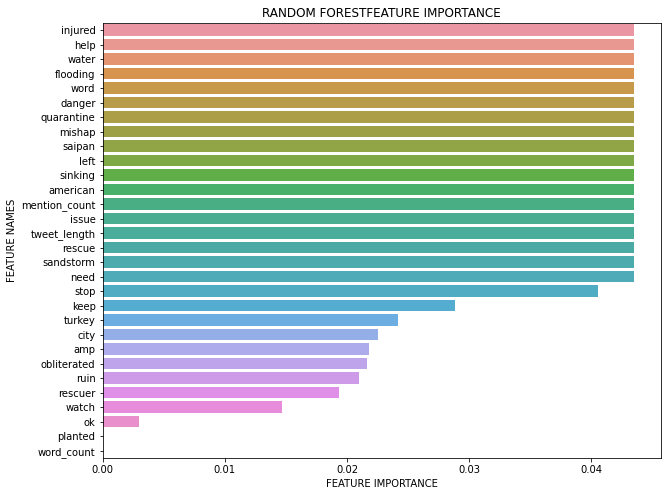

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns 
plot_feature_importance(rf_model.feature_importances_,  AUX.columns,'RANDOM FOREST')


In [ ]:
#foward Selection

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


('9', '14', '17', '1377', '3526', '3811', '4469', '5206', '5455', '6079', '6120', '6533', '7866', '8953', '9797')


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


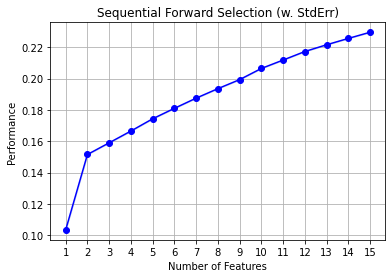

In [77]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
           k_features=(1,15),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
sfs.fit(X_train, y_train)
print(sfs.k_feature_names_ )  
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()